# Kaggle Lending Club Loan Data
##### Created: October 11, 2018
##### Last Updated: October 12, 2018
##### Author: Zack Pollak <<zapollak@gmail.com>>

## Part 1

### Import Python packages

In [243]:
from __future__ import print_function
import datetime
import itertools
import re
import numpy as np
import pandas as pd
import sqlite3
import scipy
import sklearn
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Ignore pandas warnings when writing slice back to orig df
pd.options.mode.chained_assignment = None  # default='warn'
# Display all columns when viewing pandas df
pd.set_option('display.max_columns', None)
# Set plotly offline notebook mode
init_notebook_mode(connected=True)

#### A few user-defined functions to help later with model assessment

In [253]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_metrics(cm):
    """
    Metrics on confusion matrix for binary classification where
    cm is 2D np.array of form [[TP, FN], [FP, TN]]
    """
    cm = cm.astype(float)
    print('Accuracy = ' + str((cm[0][0] + cm[1][1]) / cm.sum()))
    print('Misclassification Rate = ' + str((cm[0][1] + cm[1][0]) / cm.sum()))
    print('TP Rate = ' + str(cm[1][1] / cm.sum(axis=1)[1]))
    print('FP Rate = ' + str(cm[1][0] / cm.sum(axis=1)[1]))
    print('TN Rate = ' + str(cm[0][0] / cm.sum(axis=1)[0]))
    print('FN Rate = ' + str(cm[0][1] / cm.sum(axis=1)[0]))
    print('Specifity = ' + str(cm[1][1] / cm.sum(axis=1)[1]))
    print('Precision = ' + str(cm[0][0] / cm.sum(axis=0)[0]))
    print('Prevalence = ' + str(cm.sum(axis=1)[0] / cm.sum()))

### Pull data into environment

In [2]:
df = pd.read_csv('lc_loan_data/loan.csv', low_memory=False)

In [3]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's check the dataframe dimensions.

In [4]:
def df_shape(data):
    print('Number of columns: ' + str(data.shape[1]))
    print('Number of rows: ' + str(data.shape[0]))

In [5]:
df_shape(df)

Number of columns: 74
Number of rows: 887379


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

Looking at the initial information on the data shows that there are a lot of missing values. The rightmost part of the dataframe looks to be pretty sparse with a lot of fields having only 21,372 non-null values.

### Subset columns for EDA

In [7]:
fields = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc', 
          'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']
df_eda = df[fields]

In [8]:
df_eda.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [9]:
df_shape(df_eda)

Number of columns: 11
Number of rows: 887379


### Grab summary statistics for the new dataset

In [10]:
df_eda.describe()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,8.873790e+05,887379.000000
mean,14755.264605,14741.877625,13.246740,7.502759e+04,18.157039,1.692079e+04,7558.826684
std,8435.455601,8429.897657,4.381867,6.469830e+04,17.190626,2.242679e+04,7871.243336
min,500.000000,500.000000,5.320000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8000.000000,8000.000000,9.990000,4.500000e+04,11.910000,6.443000e+03,1914.590000
50%,13000.000000,13000.000000,12.990000,6.500000e+04,17.650000,1.187500e+04,4894.999117
75%,20000.000000,20000.000000,16.200000,9.000000e+04,23.950000,2.082900e+04,10616.814231
max,35000.000000,35000.000000,28.990000,9.500000e+06,9999.000000,2.904836e+06,57777.579870


For all numerical variables, the mean is greater than the median indicating a positive skew.

### Missing data

In [11]:
print('Which columns have null values?\n')
print(df_eda.isnull().any())

print('\n')

print('How many null values does each column have?\n')
print(df_eda.isnull().sum().sort_values(ascending=False))

Which columns have null values?

loan_amnt      False
funded_amnt    False
term           False
int_rate       False
grade          False
annual_inc      True
issue_d        False
dti            False
revol_bal      False
total_pymnt    False
loan_status    False
dtype: bool


How many null values does each column have?

annual_inc     4
loan_status    0
total_pymnt    0
revol_bal      0
dti            0
issue_d        0
grade          0
int_rate       0
term           0
funded_amnt    0
loan_amnt      0
dtype: int64


There are only 4 missing values in the dataset. Let's take a look at them.

In [12]:
df_eda[df_eda['annual_inc'].isnull()]

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
42449,5000.0,5000.0,36 months,7.43,A,NaN,Aug-2007,1.0,0.0,5593.46,Does not meet the credit policy. Status:Fully ...
42450,7000.0,7000.0,36 months,7.75,A,NaN,Aug-2007,1.0,0.0,7867.53,Does not meet the credit policy. Status:Fully ...
42480,6700.0,6700.0,36 months,7.75,A,NaN,Jul-2007,1.0,0.0,7530.42,Does not meet the credit policy. Status:Fully ...
42533,6500.0,6500.0,36 months,8.38,A,NaN,Jun-2007,4.0,0.0,7373.83,Does not meet the credit policy. Status:Fully ...


All 4 rows with a missing value for **annual_inc** is a loan that does not meet the credit policy with notes that it was fully paid. Looking at the **total_pymnt** field, I would assume that these are old loans which have been paid, however, they no longer meet the current credit policy.
<br>
<br>
As you need to provide your annual income to get a loan, I do not think that these are records where the borrower did not provide information. I think it is safe to remove these records from the dataset rather than perform imputation.

In [13]:
init_len = df_eda.shape[0]
df_eda = df_eda.dropna()
new_len = df_eda.shape[0]
print('{} rows were dropped from the dataset. This is a {:.2f}% reduction of rows.'.format(init_len - new_len, 100*(init_len - new_len)/float(init_len)))

4 rows were dropped from the dataset. This is a 0.00% reduction of rows.


In [14]:
df_shape(df_eda)

Number of columns: 11
Number of rows: 887375


### Distribution of categorical variables

We will take a look at the value counts for **grade**, **term**, and **loan_status**. While **issue_d** is currently strictly categorical due to the formatting. It makes sense to look at the distribution at the moment but I assume it will be dispersed across all months from 2007-2015.
<br>
<br>
It is worth noting that it makes sense to transform **term** into a numerical variable by removing the 'months' suffix resulting in values of 36 or 60. It will clearly still only have 2 levels.

#### Grade (grade)

In [15]:
print('Grade Counts')
pd.value_counts(df_eda['grade']).to_frame().reset_index()

Grade Counts


,index,grade
0,B,254535
1,C,245860
2,A,148198
3,D,139542
4,E,70705
5,F,23046
6,G,5489


In [16]:
print('Grade Bucket Counts and Percentages\n\n')
print('Number of mid-grade loans (B/C/D): ' + str(df_eda[df_eda['grade'].isin(['B', 'C', 'D'])]['grade'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_eda[df_eda['grade'].isin(['B', 'C', 'D'])]['grade'].count() / float(df_eda.shape[0])))
print('\n')

print('Number of high-grade loans (A): ' + str(df_eda[df_eda['grade'] == 'A']['grade'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_eda[df_eda['grade'] == 'A']['grade'].count() / float(df_eda.shape[0])))
print('\n')

print('Number of low-grade loans (E/F/G): ' + str(df_eda[df_eda['grade'].isin(['E', 'F', 'G'])]['grade'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_eda[df_eda['grade'].isin(['E', 'F', 'G'])]['grade'].count() / float(df_eda.shape[0])))

Grade Bucket Counts and Percentages


Number of mid-grade loans (B/C/D): 639937
Percentage of total loans: 72.12%


Number of high-grade loans (A): 148198
Percentage of total loans: 16.70%


Number of low-grade loans (E/F/G): 99240
Percentage of total loans: 11.18%


A majority of loans are mid-grade (B/C/D), followed by high-grade (A) loans with risky, low-grade (E/F/G) loans making up the tail. This distribution makes sense as I would not expect a majority of loans to be high-grade and at the same time Lending Club does not want a lot of risky loans.

#### Term (term)

In [17]:
print('Term Counts')
pd.value_counts(df_eda['term']).to_frame().reset_index()

Term Counts


,index,term
0,36 months,621121
1,60 months,266254


In [18]:
print('Term Percentages')
pd.value_counts(df_eda['term'], normalize=True).to_frame().reset_index()

Term Percentages


,index,term
0,36 months,0.699953
1,60 months,0.300047


The loans in the dataset only have 36-month and 60-month terms as noted in the data dictionary. 70% of the loans have 36-month terms while the remaining 30% have 60-month terms. This is a clear indication that a majority of the loans through Lending Club are shorter-term loans.

#### Loan status (loan_status)

In [19]:
print('Loan Status Counts')
pd.value_counts(df_eda['loan_status']).to_frame().reset_index()

Loan Status Counts


,index,loan_status
0,Current,601779
1,Fully Paid,207723
2,Charged Off,45248
3,Late (31-120 days),11591
4,Issued,8460
5,In Grace Period,6253
6,Late (16-30 days),2357
7,Does not meet the credit policy. Status:Fully ...,1984
8,Default,1219
9,Does not meet the credit policy. Status:Charge...,761


In [20]:
print('Loan Status Percentages')
pd.value_counts(df_eda['loan_status'], normalize=True).to_frame().reset_index()

Loan Status Percentages


,index,loan_status
0,Current,0.678156
1,Fully Paid,0.234087
2,Charged Off,0.050991
3,Late (31-120 days),0.013062
4,Issued,0.009534
5,In Grace Period,0.007047
6,Late (16-30 days),0.002656
7,Does not meet the credit policy. Status:Fully ...,0.002236
8,Default,0.001374
9,Does not meet the credit policy. Status:Charge...,0.000858


A majority of the loans are current (67.8%) with the second largest group being those that have been fully paid (23.4%). There are a fair amount of loans which have been charged off (5%) and an even smaller percentage which are late (~1.5%). Loans that have defaulted constitute a very small portion of the dataset (0.1%) which is a good sign for Lending Club.
<br>
<br>
There are still loans in the dataset with a loan status indicating that they do not meet the credit policy (2,745 or 0.3%). From a consistency standpoint, it would make sense to remove these loans as we did earlier with the loans that were missing data for **annual_inc**.
<br>
##### Let's remove the loans that do not meet the credit policy

In [21]:
init_len = df_eda.shape[0]
df_eda = df_eda[~df_eda['loan_status'].str.contains('Does not meet', na=False)]
new_len = df_eda.shape[0]
print('{} rows were dropped from the dataset. This is a {:.2f}% reduction of rows.'.format(init_len - new_len, 100*(init_len - new_len)/float(init_len)))

2745 rows were dropped from the dataset. This is a 0.31% reduction of rows.


#### Issue Date (issue_d)

In [26]:
print('Issue Date counts')
pd.value_counts(df_eda['issue_d']).to_frame().reset_index()

Issue Date counts


,index,issue_d
0,Oct-2015,48631
1,Jul-2015,45962
2,Dec-2015,44342
3,Oct-2014,38782
4,Nov-2015,37530
5,Aug-2015,35886
6,Apr-2015,35427
7,Jan-2015,35107
8,May-2015,31913
9,Jul-2014,29306


In [27]:
print('Issue Date percentages')
pd.value_counts(df_eda['issue_d'], normalize=True).to_frame().reset_index()

Issue Date percentages


,index,issue_d
0,Oct-2015,0.054973
1,Jul-2015,0.051956
2,Dec-2015,0.050125
3,Oct-2014,0.043840
4,Nov-2015,0.042425
5,Aug-2015,0.040566
6,Apr-2015,0.040047
7,Jan-2015,0.039686
8,May-2015,0.036075
9,Jul-2014,0.033128


As suspected, the loans are distributed across all months from mid-2007 through the end of 2015. Interestingly, the latter years tend to contain a majority of the loans. I assume this is due to the financial crisis of 2007-08.

### Transformations

Let's transform the non-numerical fields from **df_eda** into numerical fields so that we may run some more in-depth analysis.
<li> Remove the 'months' string from **term** (e.g. '36 months' to 36)
<li> Encode **grade** to numerical (e.g. 'A' = 0, 'B' = 1, etc.)
<li> Transform **issue_d** into date
<li> Encode **loan_status** as numerical (e.g. 'Fully Paid' = 0, 'Charged Off' = 1, etc.)

In [28]:
df_eda.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [29]:
df_num = df_eda.copy()
df_num.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
1,2500.0,2500.0,60 months,15.27,C,30000.0,Dec-2011,1.00,1687.0,1008.710000,Charged Off
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
4,3000.0,3000.0,60 months,12.69,B,80000.0,Dec-2011,17.94,27783.0,3242.170000,Current


In [30]:
# term
df_num['term'] = df_num['term'].apply(lambda x: re.findall(r'\d+', x))
df_num['term'] = df_num['term'].apply(lambda x: int(x[0]))

# grade
le = pp.LabelEncoder()
le.fit(df_num['grade'])
df_num['grade'] = le.transform(df_num['grade'])

# issue_d
df_num['issue_d'] = pd.to_datetime(df_num['issue_d'])

# loan_status
le = pp.LabelEncoder()
le.fit(df_num['loan_status'])
df_num['loan_status'] = le.transform(df_num['loan_status'])

In [31]:
df_num.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36,10.65,1,24000.0,2011-12-01,27.65,13648.0,5861.071414,3
1,2500.0,2500.0,60,15.27,2,30000.0,2011-12-01,1.00,1687.0,1008.710000,0
2,2400.0,2400.0,36,15.96,2,12252.0,2011-12-01,8.72,2956.0,3003.653644,3
3,10000.0,10000.0,36,13.49,2,49200.0,2011-12-01,20.00,5598.0,12226.302212,3
4,3000.0,3000.0,60,12.69,1,80000.0,2011-12-01,17.94,27783.0,3242.170000,1


### Correlation matrix (heatmap)

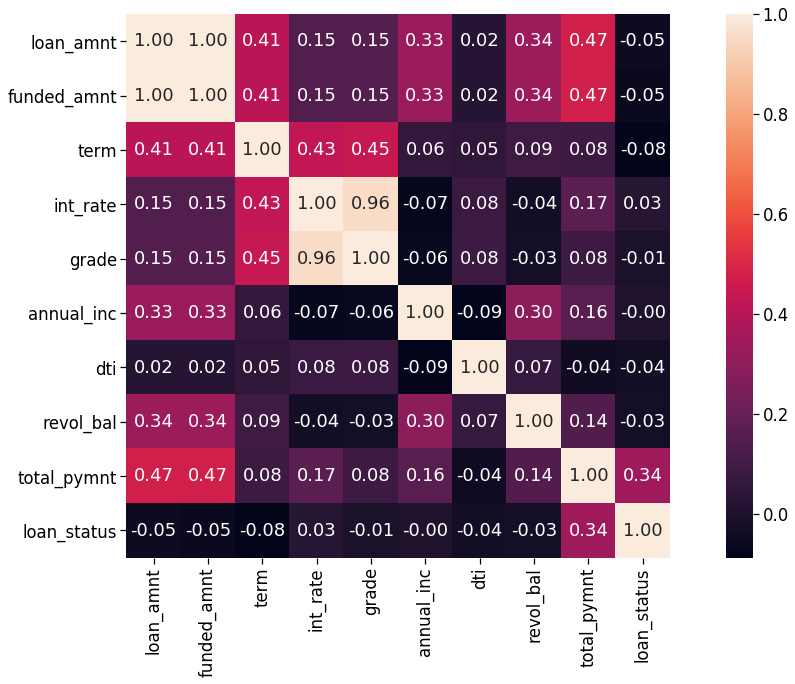

In [32]:
%matplotlib inline
plt.figure(figsize=(20,10))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(df_num.corr(), vmax=1, square=True, annot=True, fmt='.2f')

##### Summary:
<li> **loan_amnt** and **funded_amnt** have a perfect correlation of 1
<li> The second highest correlation is between **grade** and **int_rate** (0.96); this more than likely implies that one is used to determine the other
<li> **grade** is also decently correlated with **term** (0.45); regarding the last bullet, **int_rate** is also rather correlated with **term** though not identical to **grade**/**term** correlation (0.43)
<li> There is pretty strong correlation between **total_pymnt** and **loan_amnt**/**funded_amnt** (0.47)
<li> There aren't many variables that are inversely correlated with the largest being **dti** and **annual_inc** (-0.09) 

### Average Loan Amount by Grade

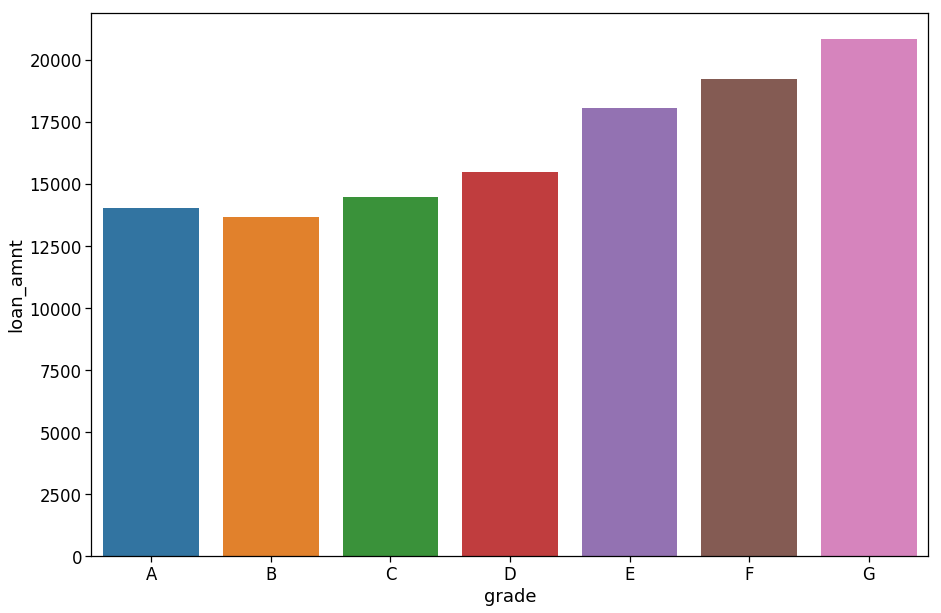

In [33]:
by_grade = df_eda.groupby('grade').mean()
avg_loan_amnt = by_grade['loan_amnt'].reset_index()
plt.subplots(figsize=(15,10))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan_amnt)

In [34]:
avg_loan_amnt.sort_values('loan_amnt', ascending=False)

,grade,loan_amnt
6,G,20855.868744
5,F,19217.782578
4,E,18071.066995
3,D,15494.357081
2,C,14480.310503
0,A,14044.276151
1,B,13650.167695


##### Summary
When looking at loan amounts (**loan_amnt**) by **grade**, we can see that riskier loans have higher average loan amounts. This seems like a recipe for disaster but at the same time, I am led to believe that **loan_amnt** is used to calculate the **grade** and higher loan amounts will result in a lower **grade**. The only outlier to this trend is that the average loan amount for grade A loans is larger than grade B loans.

### Average Total Payment by Loan Status

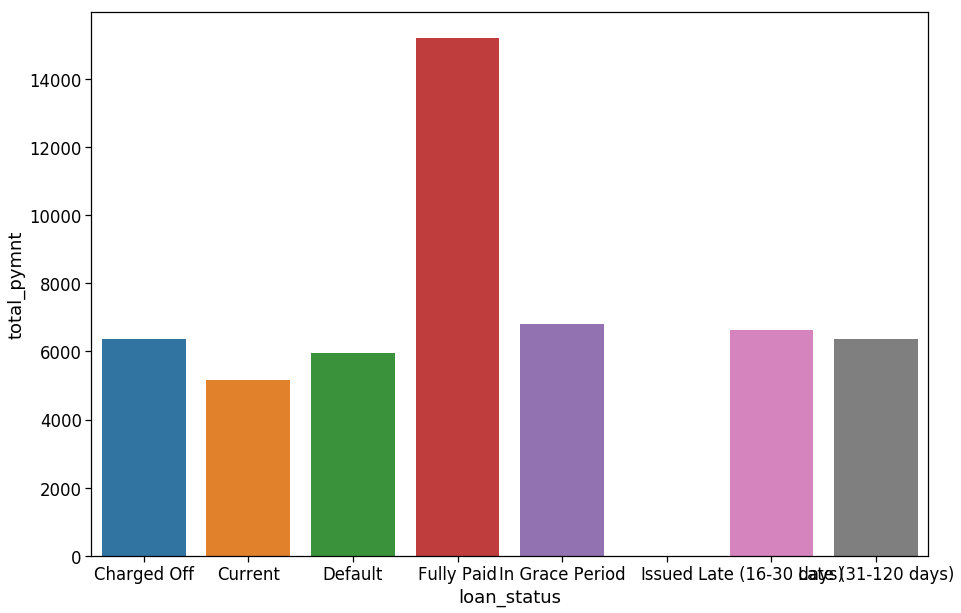

In [35]:
by_status = df_eda.groupby('loan_status').mean()
avg_total_pymnt = by_status['total_pymnt'].reset_index()
plt.subplots(figsize=(15,10))
sns.barplot(x='loan_status', y='total_pymnt', data=avg_total_pymnt)

In [36]:
avg_total_pymnt.sort_values('total_pymnt', ascending=False)

,loan_status,total_pymnt
3,Fully Paid,15186.680773
4,In Grace Period,6792.092241
6,Late (16-30 days),6617.883309
0,Charged Off,6369.612648
7,Late (31-120 days),6367.870714
2,Default,5947.982329
1,Current,5152.886189
5,Issued,9.307895


##### Summary
We dug into the total payment amount (**total_pymnt**) by **loan_status** because **total_pymnt** had the highest correlation with **loan_status** out of all variables. One can see that the Fully Paid loans have the largest average total payment. This makes perfect sense as the loans were paid off. The loans with a status indicating they are late have a higher average total payment amount than those with a status of 'Current' which is probably due to interest.

### Distribution of Loan Amount

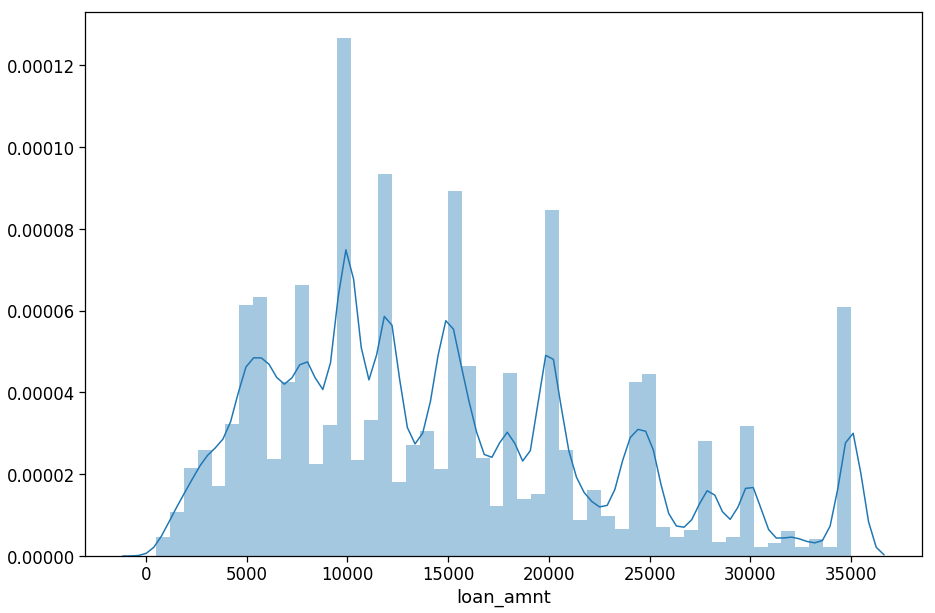

In [37]:
plt.subplots(figsize=(15,10))
sns.distplot(df['loan_amnt'])

In [38]:
from scipy.stats import skew, kurtosis
print('The skewness of ''loan_amnt'' is: {:.3f}'.format(skew(df_eda['loan_amnt'])))
print('The excess kurtosis of ''loan_amnt'' is: {:.3f}'.format(kurtosis(df_eda['loan_amnt'])))

The skewness of loan_amnt is: 0.681
The excess kurtosis of loan_amnt is: -0.259


##### Summary
<li> As seen in the **loan_amnt** distribution plot, there is tail to the right; the positive skew value of 0.681 confirms this
<li> The kurtosis value of -0.259 indicates that the peakedness is pretty close to normal

## Part 2

Create a dataset containing strictly 36 month loans.

In [128]:
df_36 = df_eda.copy()
df_36 = df_36[df_36['term'].str.contains('36')]
df_36_num = df_num.copy()
df_36_num = df_36_num[df_36_num['term'] == 36]

In [129]:
print(df_36.shape)
df_36.head()

(618687, 11)


,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid
5,5000.0,5000.0,36 months,7.90,A,36000.0,Dec-2011,11.20,7963.0,5631.377753,Fully Paid
7,3000.0,3000.0,36 months,18.64,E,48000.0,Dec-2011,5.35,8221.0,3938.144334,Fully Paid


In [130]:
print('Term Counts')
pd.value_counts(df_36['term']).to_frame().reset_index()

Term Counts


,index,term
0,36 months,618687


In [131]:
print(df_36_num.shape)
df_36_num.head()

(618687, 11)


,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status
0,5000.0,5000.0,36,10.65,1,24000.0,2011-12-01,27.65,13648.0,5861.071414,3
2,2400.0,2400.0,36,15.96,2,12252.0,2011-12-01,8.72,2956.0,3003.653644,3
3,10000.0,10000.0,36,13.49,2,49200.0,2011-12-01,20.00,5598.0,12226.302212,3
5,5000.0,5000.0,36,7.90,0,36000.0,2011-12-01,11.20,7963.0,5631.377753,3
7,3000.0,3000.0,36,18.64,4,48000.0,2011-12-01,5.35,8221.0,3938.144334,3


In [132]:
print('Term Counts')
pd.value_counts(df_36_num['term']).to_frame().reset_index()

Term Counts


,index,term
0,36,618687


After performing sanity check, data looks good to proceed.

### #1
Percentage of loans fully paid.

In [133]:
print('Number of Fully Paid 36-month loans: ' + str(df_36[df_36['loan_status'] == 'Fully Paid']['loan_status'].count()))
print('Percentage of total loans: {:.2f}%'.format(100*df_36[df_36['loan_status'] == 'Fully Paid']['loan_status'].count() / float(df_36.shape[0])))

Number of Fully Paid 36-month loans: 167575
Percentage of total loans: 27.09%


##### 27.09% of the 36-month loans have been fully paid.

### #2
Bucket by origination year and grade. Which bucket has highest rate of default?
<br>
Assume that any loan not fully paid has defaulted.

In [134]:
# Convert to date then year
df_36['orig_year'] = pd.to_datetime(df_36['issue_d'])
df_36['orig_year'] = df_36['orig_year'].apply(lambda x: x.year)

# Group year and grade
df_36['year_grade'] = df_36['orig_year'].map(str) + ' ' + df_36['grade'].map(str)

# Create default variable; if 'Fully Paid' then 'No' else 'Yes'
df_36['default'] = np.where(df_36['loan_status'] == 'Fully Paid', 'No', 'Yes')

In [135]:
df_36_default = df_36[df_36['default'] == 'Yes']
pd.value_counts(df_36_default['default']).to_frame().reset_index()

,index,default
0,Yes,451112


In [136]:
pd.value_counts(df_36_default['year_grade'], normalize=True).to_frame().reset_index().head(10)

,index,year_grade
0,2015 B,0.193065
1,2015 C,0.160016
2,2015 A,0.148515
3,2014 B,0.086963
4,2014 C,0.072113
5,2015 D,0.066977
6,2014 A,0.059129
7,2013 B,0.047252
8,2014 D,0.033814
9,2013 C,0.029966


##### Loans that originated in 2015 with a B grade constitute the largest portion of loans that have defaulted.

### #3
Bucket by origination year and grade. What annualized rate of return have the loans generated on average?
<br>
Assume that `Annualized Rate of Return = (total_pymnt / funded_amnt -1) ^ (1/3)`.

In [137]:
from __future__ import division
df_36['ann_rate'] = (df_36['total_pymnt'] / df_36['funded_amnt'] - 1) ** (1/3)

In [138]:
print('Overall average rate of return: ' + str(df_36['ann_rate'].mean()))

by_year_grade = df_36.groupby('year_grade').mean()
avg_ann_rate = by_year_grade['ann_rate'].reset_index()
avg_ann_rate.sort_values('ann_rate', ascending=False).head(10)

Overall average rate of return: 0.475485541756


,year_grade,ann_rate
33,2011 G,0.683785
40,2012 G,0.674487
26,2010 G,0.671978
39,2012 F,0.661811
38,2012 E,0.648165
32,2011 F,0.628126
31,2011 E,0.627589
11,2008 F,0.618044
37,2012 D,0.617703
12,2008 G,0.612983


##### Looking at all of the loans, the average annual rate of return was 0.475.

##### Looking at buckets, loans that originated in 2011 (0.684), 2012 (0.674), and 2010 (0.672) with a G grade had the highest average annual rates of return.

## Part 3

Building off of Part 2, build a logistic regression model that predicts loan defaults as defined above (if loan_status == 'Fully Paid' then 0 else 1).

Assume that (i) you are given the ability to invest in each loan independently; (ii) you invest immediately following loan origination and hold to maturity (36 months); and (iii) all loan fields that would be known upon origination are made available to you.

In [202]:
df_3 = df_36.copy()
df_3.head()

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,loan_status,orig_year,year_grade,default,ann_rate
0,5000.0,5000.0,36 months,10.65,B,24000.0,Dec-2011,27.65,13648.0,5861.071414,Fully Paid,2011,2011 B,No,0.556361
2,2400.0,2400.0,36 months,15.96,C,12252.0,Dec-2011,8.72,2956.0,3003.653644,Fully Paid,2011,2011 C,No,0.631237
3,10000.0,10000.0,36 months,13.49,C,49200.0,Dec-2011,20.00,5598.0,12226.302212,Fully Paid,2011,2011 C,No,0.606077
5,5000.0,5000.0,36 months,7.90,A,36000.0,Dec-2011,11.20,7963.0,5631.377753,Fully Paid,2011,2011 A,No,0.501695
7,3000.0,3000.0,36 months,18.64,E,48000.0,Dec-2011,5.35,8221.0,3938.144334,Fully Paid,2011,2011 E,No,0.678760


#### Update the df_3 dataframe to be numerical (run same transformations that were used to create df_36_num)
<li> Remove the **year_grade** feature that was created for bucketing purposes
<li> Remove the **loan_status** feature because we will be using the **default** field as our target variable.
<li> Drop the **term** feature because it has no predictive power due to lack of variance (every value = '36 months').
<li> Encode **grade** to numerical (e.g. 'A' = 0, 'B' = 1, etc.)
<li> Transform **issue_d** into date
<li> Transform **default** to binary 1/0 rather than Yes/No

In [203]:
# Drop year_grade
df_3 = df_3.drop('year_grade', axis=1)

# Drop loan_status
df_3 = df_3.drop('loan_status', axis=1)

# Drop term
df_3 = df_3.drop('term', axis=1)

# Convert to date then year
df_3['orig_year'] = pd.to_datetime(df_3['issue_d'])
df_3['orig_year'] = df_3['orig_year'].apply(lambda x: x.year)

# grade
le = pp.LabelEncoder()
le.fit(df_3['grade'])
df_3['grade'] = le.transform(df_3['grade'])

# issue_d
df_3['issue_d'] = pd.to_datetime(df_3['issue_d'])

# default
df_3['default'] = np.where(df_3['default'] == 'Yes', 1, 0)

#### ann_rate will be null for any value where the total_pymnt is less than funded_amnt
These null values cannot be fed into our model. While I would love to just remove them and use the annual rate as an input, this would skew the model. We cannot only look at loans where the **total_pymnt** is greater than the **funded_amnt** when we are trying to predict loan defaults.
<br>
We should remove the **ann_rate** feature from our dataset.

In [204]:
df_3 = df_3.drop('ann_rate', axis=1)

In [205]:
df_3.head()

,loan_amnt,funded_amnt,int_rate,grade,annual_inc,issue_d,dti,revol_bal,total_pymnt,orig_year,default
0,5000.0,5000.0,10.65,1,24000.0,2011-12-01,27.65,13648.0,5861.071414,2011,0
2,2400.0,2400.0,15.96,2,12252.0,2011-12-01,8.72,2956.0,3003.653644,2011,0
3,10000.0,10000.0,13.49,2,49200.0,2011-12-01,20.00,5598.0,12226.302212,2011,0
5,5000.0,5000.0,7.90,0,36000.0,2011-12-01,11.20,7963.0,5631.377753,2011,0
7,3000.0,3000.0,18.64,4,48000.0,2011-12-01,5.35,8221.0,3938.144334,2011,0


#### Feature Selection

#### Test for multicollinearity via correlation matrix (heatmap)

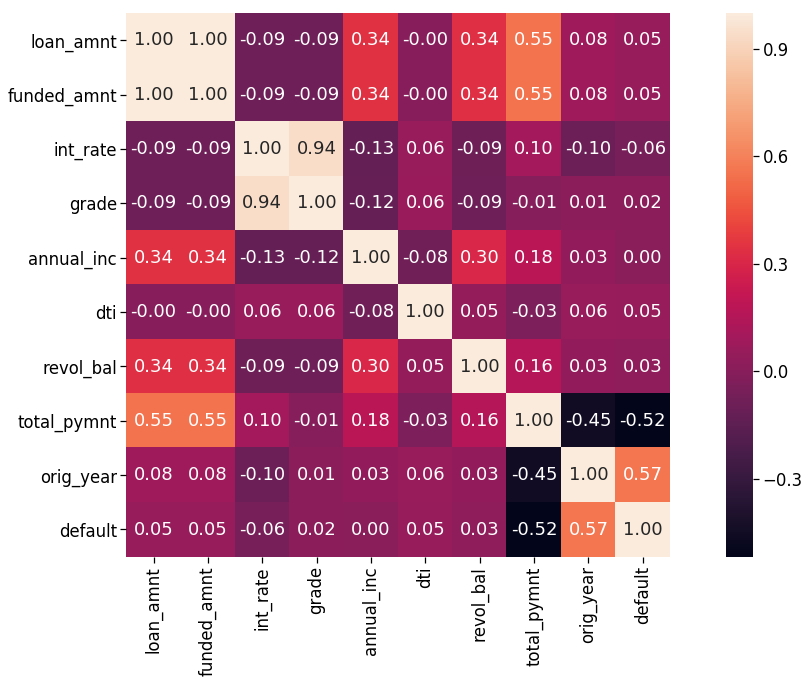

In [206]:
%matplotlib inline
plt.figure(figsize=(20,10))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(df_3.corr(), vmax=1, square=True, annot=True, fmt='.2f')

##### Summary
<li> **loan_amnt** and **funded_amnt** have a correlation of 1 so we can remove one of these features; they both have the same correlation to the target variable, **default**, so it won't matter which we keep in our model
<li> **grade** and **int_rate** have a strong correlation fo 0.94 so let's remove one of these features as well; **int_rate** has a stronger absolute correlation with **default** so let's remove **grade**
<li> Let's go with **orig_year** rather than **issue_d** for the date feature; when looking at the correlation matrix and analysis from part 2, it seems it will be a good feature; I don't think it's necessary to look at the date on a monthly level
<li> Let's take a quick peak at how many loans have **loan_amnt** not equal to **funded_amnt**

In [207]:
print('Number of loans where ''loan_amnt'' is not equal to ''funded_amnt'': ' + str(df_3[df_3['loan_amnt'] != df_3['funded_amnt']].shape[0]))
print('Percentage of loans in dataset: {:.2f}%'.format(100 * df_3[df_3['loan_amnt'] != df_3['funded_amnt']].shape[0] / float(df_3.shape[0])))

Number of loans where loan_amnt is not equal to funded_amnt: 769
Percentage of loans in dataset: 0.12%


It is such a small percentage of loans which is why the correlation of the 2 features with every other feature is the same (to 2 decimal places). I think it makes more sense to go with the **loan_amnt** beacause the data dictionary says that if at some point the credit department reduces the loan amount, it is reflected in this value.

In [208]:
X, y = df_3.drop(['default', 'funded_amnt', 'grade', 'issue_d'], axis=1), df_3['default']

In [209]:
X.head()

,loan_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,orig_year
0,5000.0,10.65,24000.0,27.65,13648.0,5861.071414,2011
2,2400.0,15.96,12252.0,8.72,2956.0,3003.653644,2011
3,10000.0,13.49,49200.0,20.00,5598.0,12226.302212,2011
5,5000.0,7.90,36000.0,11.20,7963.0,5631.377753,2011
7,3000.0,18.64,48000.0,5.35,8221.0,3938.144334,2011


#### Split into train and test sets

Split the dataset into train and test sets for the logistic regression model. The train/test split should be 70%/30%. We will set a random seed to initialize the sampling.

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

#### Build model
We will use the default parameters for the sake of simplicity.
1. Create model with sklearn LogisticRegression()
2. Fit the model
3. Predict
4. Assess accuracy

In [232]:
clf = LogisticRegression()

In [233]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [234]:
preds = clf.predict(X_test)

In [235]:
print('Accuracy Score: ' + str(accuracy_score(y_test, preds)))
print('AUC of ROC: ' + str(roc_auc_score(y_test, preds)))
print('Cross-validation Score: ' + str(cross_val_score(clf, X_train, y_train).mean()))

Accuracy Score: 0.960885095928
AUC of ROC: 0.967970510179
Cross-validation Score: 0.960792463286


##### Summary
<li> The model performed strongly with an accuracy classification score of 0.961 (meaning it correctly predicted loan default 96.1% of the time).
<li> The area under the ROC was used as a second form of validating model accuracy. The score of 0.967 is very close to 1 implying that the model does a good job of differentiating between loans that do/do not default.
<li> The cross-validation score of 0.961 is also strong. This method applies k-fold cross validation which can be used to evaluate and compare models. A higher value indicates a stronger model.

#### Appy Recursive Feature Elimination
Let's apply RFE to see if we can generate a stronger logistic regression model.

In [237]:
rfe = RFE(clf)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0)

In [238]:
print("Num Features: %d"% rfe.n_features_)
print("Selected Features: %s"% rfe.support_)
print("Feature Ranking: %s"% rfe.ranking_)

Num Features: 3
Selected Features: [ True  True False False False  True False]
Feature Ranking: [1 1 5 2 4 1 3]


In [239]:
X_train.head()

,loan_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,orig_year
619590,2800.0,12.69,28000.0,25.63,8989.0,373.75,2015
493417,3200.0,13.18,24000.0,3.60,422.0,105.76,2015
533316,12000.0,10.99,30000.0,4.35,3384.0,770.97,2015
773334,4800.0,14.65,26000.0,26.50,5287.0,1320.73,2015
631820,6000.0,6.89,44400.0,34.38,2444.0,735.29,2015


##### Summary
RFE has identified that **loan_amnt**, **int_rate**, and **total_pymnt** are the strongest features in our logistic regression model. Let's limit the feature space to these 3 variables and create a new model.

#### Build new model

In [248]:
X_train_2 = X_train[['loan_amnt', 'int_rate', 'total_pymnt']]
X_test_2 = X_test[['loan_amnt', 'int_rate', 'total_pymnt']]
clf = LogisticRegression()
clf.fit(X_train_2, y_train)
preds = clf.predict(X_test_2)
print('Accuracy Score: ' + str(accuracy_score(y_test, preds)))
print('AUC of ROC: ' + str(roc_auc_score(y_test, preds)))
print('Cross-validation Score: ' + str(cross_val_score(clf, X_train, y_train).mean()))

Accuracy Score: 0.966585311976
AUC of ROC: 0.973799341661
Cross-validation Score: 0.960794772328


Confusion matrix, without normalization
[[ 49725    526]
 [  5676 129680]]
Accuracy = 0.966585311976
Misclassification Rate = 0.0334146880236
TP Rate = 0.958066136706
FP Rate = 0.0419338632938
TN Rate = 0.989532546616
FN Rate = 0.010467453384
Specifity = 0.958066136706
Precision = 0.897546975686
Prevalence = 0.270738711363


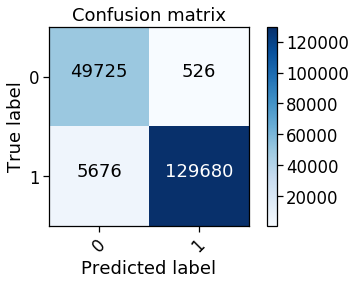

In [254]:
# Confusion matrix
cm = confusion_matrix(y_test, preds)
classes = set(y_test)
plot_confusion_matrix(cm, classes)
confusion_metrics(cm)

##### Summary
<li> The model performed strongly with an accuracy classification score of 0.967 (meaning it correctly predicted loan default 96.7% of the time). This is only a 0.006 point improvement over the classification score for the previous model.
<li> The area under the ROC is 0.973 which is even closer to 1 than our previous model. This implies that the model does a better job of differentiating between loans that do/do not default.
<li> The cross-validation score of 0.961 is also strong. This is almost equivalent to the previous model's cross-validation score.
<li> Looking at the confusion matrix for the model, we can see that the model predicts defaults when the loan has actually defaulted roughy 96% of the time and predicts no default when the loan has not defaulted roughly 99% of the time. Let's look at this from an investment perspective at the loan-level and decide we want to invest in loans that the model predicts will not default. The result will be that 90% of the loans we have invested in will not default (labeled above as precision).

#### Conclusion

##### Model Selection

Our initial model used the following features:
<li> **loan_amnt**, **int_rate**, **annual_inc**, **dti**, **revol_bal**, **total_pymnt**, **orig_year**
<br>
<br>
The second model used the following features:
<li> **loan_amnt**, **int_rate**, **total_pymnt**
<br>
<br>
The second model performed slightly better than the initial model. Reducing the feature space led to an improved classification accuracy score and larger area under the ROC (implying the model is better at differentiating between loans that default and loans that do not). While the performance of the second model is not that much better than the initial model, it makes more sense to go with this model. A smaller feature space can reduce any chance of overfitting and at the same time improves model interpretability. It is safe to say that the loan amount (**loan_amnt**), interest rate (**int_rate**), and total payment amount (**total_pymnt**) are strong features for predicting loan default. 

#### Final Model: Logistic Regression with target variable = 'default' and feature variables ['loan_amnt', 'int_rate', 'total_pymnt']